# Global Fire Emissions Database (GFED)

This shows how to load the GFED dataset into emiproc.

First we need to download the files from the [GFED website](https://www.globalfiredata.org/data.html).

For this purpose we can use the emiproc function.

In [1]:
from pathlib import Path
from emiproc.inventories.gfed import download_gfed5

local_dir = Path("./gfed5")
local_dir.mkdir(exist_ok=True)
year = 2020


In [2]:
download_gfed5(local_dir, year)

Downloaded gfed5 files for year=2020.


## Look at the files

Below we open the first file, which is the file for january.

It contains gridded emissions for every day of the mounth and for every grid cell in the domain.

In [3]:
import xarray as xr
ds = xr.open_dataset(local_dir / f"GFED5_Beta_daily_{year}01.nc")
ds

<xarray.Dataset> Size: 5GB
Dimensions:                      (lat: 720, lon: 1440, time: 31)
Coordinates:
  * lat                          (lat) float32 3kB 89.88 89.62 ... -89.62 -89.88
  * lon                          (lon) float32 6kB -179.9 -179.6 ... 179.6 179.9
  * time                         (time) datetime64[ns] 248B 2020-01-01T01:00:...
Data variables: (12/41)
    Daily fraction of emissions  (time, lat, lon) float32 129MB ...
    DM                           (time, lat, lon) float32 129MB ...
    C                            (time, lat, lon) float32 129MB ...
    CO2                          (time, lat, lon) float32 129MB ...
    CO                           (time, lat, lon) float32 129MB ...
    CH4                          (time, lat, lon) float32 129MB ...
    ...                           ...
    HCN                          (time, lat, lon) float32 129MB ...
    HCOOH                        (time, lat, lon) float32 129MB ...
    CH3COOH                      (time, lat, lon) float32 129MB ...
    MEK                          (time, lat, lon) float32 129MB ...
    CH3COCHO                     (time, lat, lon) float32 129MB ...
    HOCH2CHO                     (time, lat, lon) float32 129MB ...
Attributes:
    title:     GFED5 202001
    subtitle:  Global Fire Emissions Database (GFED) version 5 daily trace ga...

## Load with emiproc

`emiproc` hopefully makes it easy to load and process the data.
You need simply to specify which of the substances you want to load.

In [4]:
from emiproc.inventories.gfed import GFED5

gfed = GFED5(
    file_dir=local_dir, 
    year=year,
    substances=['CO2', 'CH4']
)

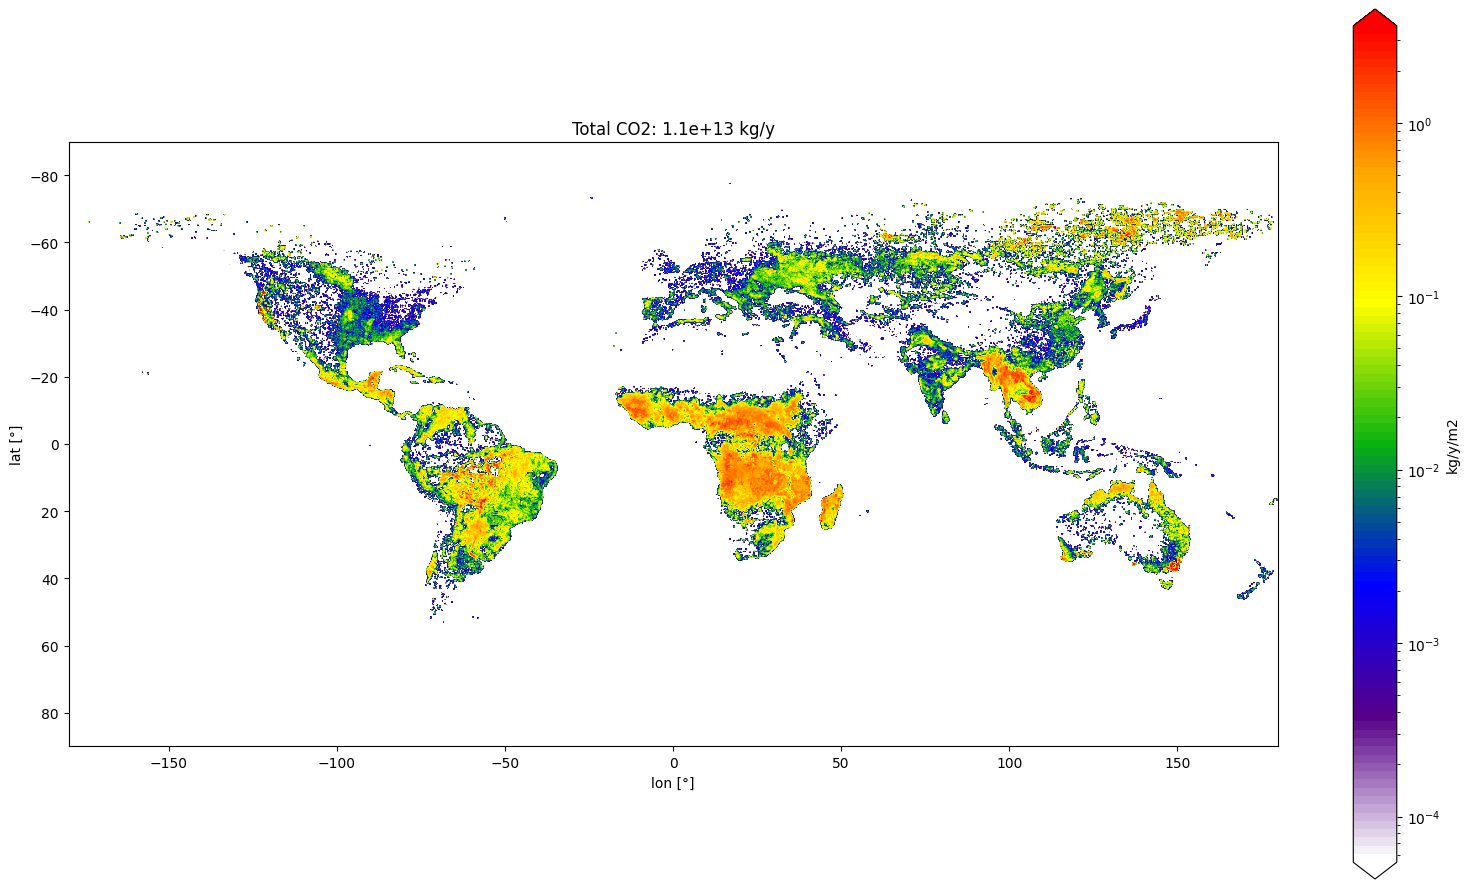

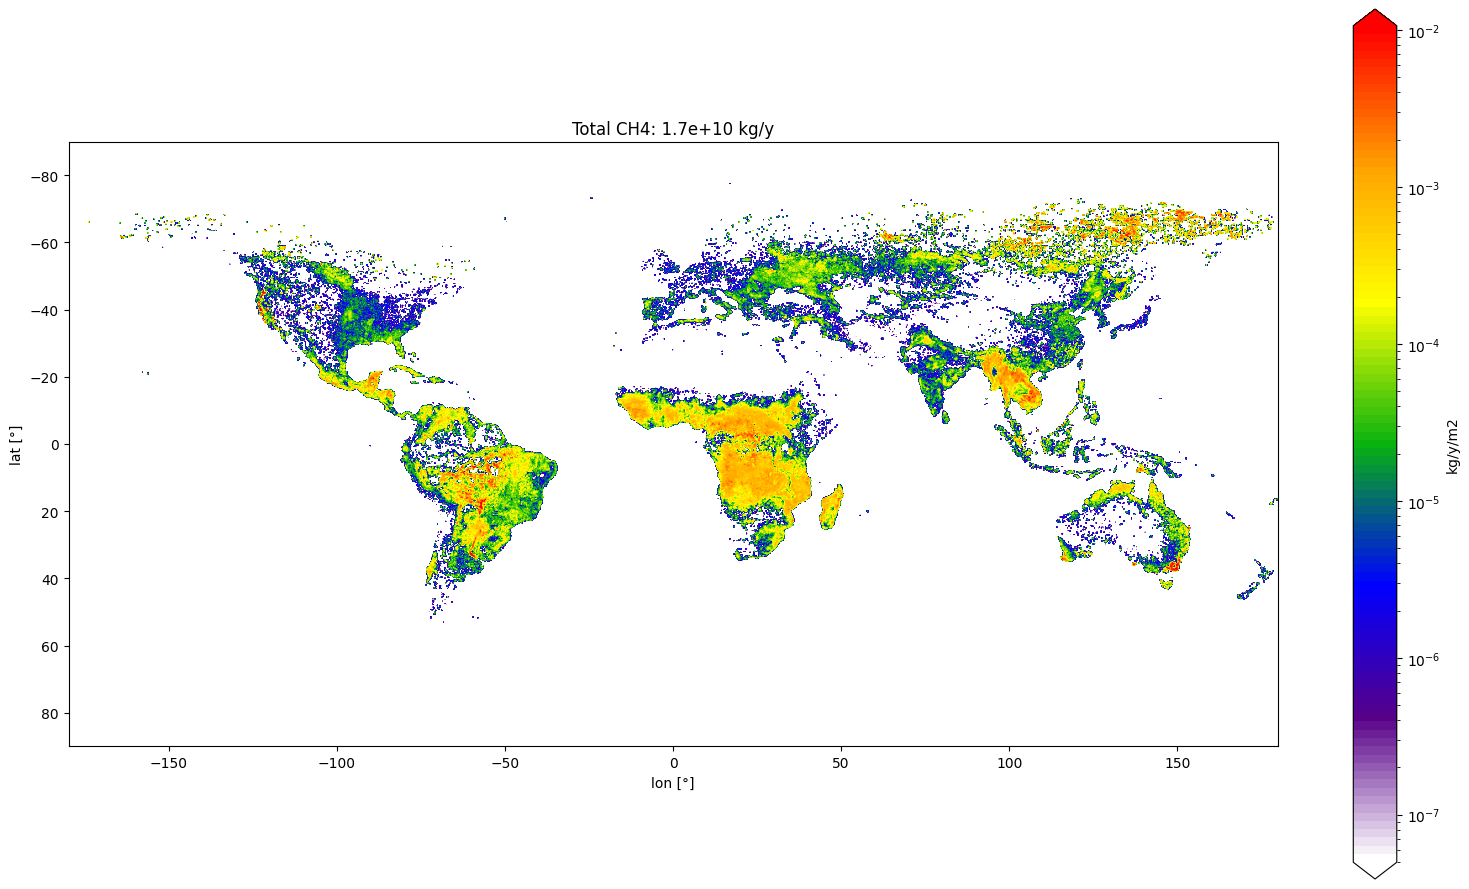

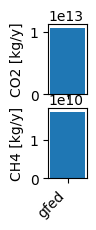

In [5]:
from emiproc.plots import plot_inventory
import matplotlib.pyplot as plt
plt.style.use("default")

plot_inventory(gfed, reverse_y=True)

## Temporal distribution

The gfed inventory also has a temporal distribution of the emissions.


With emiproc we can get the temporally distributed emissions of the inventory.
This is what we do below, where we get for each cell/day/category/substance the emissions.

In [6]:
from emiproc.exports.utils import get_temporally_scaled_array
import pandas as pd

emissions = get_temporally_scaled_array(gfed, time_range=year,  sum_over_cells=False)
emissions

<xarray.DataArray (substance: 2, category: 1, cell: 1036800, time: 366)> Size: 6GB
array([[[[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]]],


       [[[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]]]])
Coordinates:
  * substance  (substance) <U3 24B 'CO2' 'CH4'
  * category   (category) <U4 16B 'gfed'
  * cell       (cell) int32 4MB 0 1 2 3 4 ... 1036796 1036797 1036798 1036799
  * time       (time) datetime64[ns] 3kB 2020-01-01 2020-01-02 ... 2020-12-31

Now we can plot this results.

We see a large correlation between the 2 substances but we can see that the emissions are not the same.

Text(0.5, 0, 'Time')

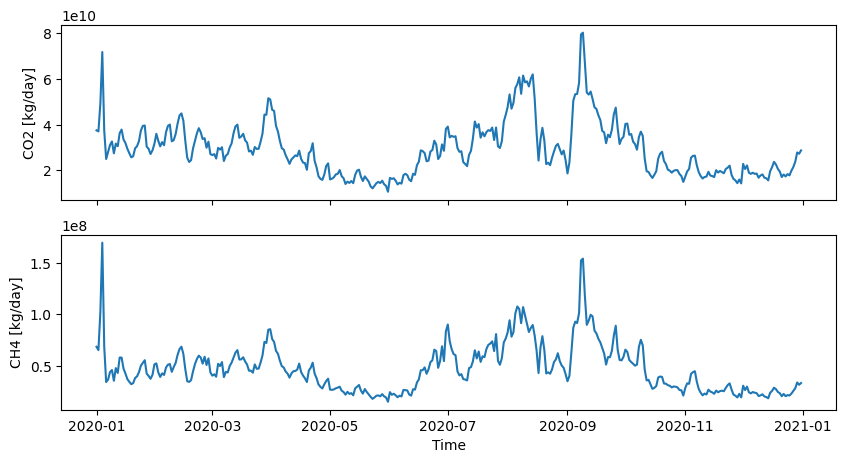

In [14]:
total = emissions.sum(dim='cell') / 365
fig, ax = plt.subplots(nrows=len(gfed.substances), figsize=(10, 5), sharex=True)
for i, substance, ax in zip(range(len(gfed.substances)), gfed.substances, ax):
    ax.plot(total['time'], total.sel(substance=substance).values.ravel())
    ax.set_ylabel(f"{substance} [kg/day]")
ax.set_xlabel("Time")